# Parallelizing Convolutional Neural Networks

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from joblib import Parallel, delayed
import networkx as nx
import time

# Importamos el dataset
from tensorflow.keras.datasets import mnist


In [10]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# Split the training data further for parallel processing
subsets = 4
X_train_splits = np.array_split(X_train, subsets)
y_train_splits = np.array_split(y_train, subsets)


In [12]:
# Define a function to train a model on a subset
def train_subset(X_subset, y_subset):
    model = MLPClassifier(hidden_layer_sizes=(128,), max_iter=10, random_state=42, verbose=False)
    model.fit(X_subset, y_subset)
    return model

# Train models in parallel
start_parallel = time.time()
parallel_models = Parallel(n_jobs=subsets)(
    delayed(train_subset)(X, y) for X, y in zip(X_train_splits, y_train_splits)
)
end_parallel = time.time()

/home/sergio/Documents/sixth/paralel/examenfinal/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sergio/Documents/sixth/paralel/examenfinal/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sergio/Documents/sixth/paralel/examenfinal/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sergio/Documents/sixth/paralel/examenfinal/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum 

In [ ]:
# Combine the predictions from each model and create a final ensemble prediction
def ensemble_predict(models, X):
    # 1. Para cada modelo en 'models', predecir las etiquetas del conjunto X
    predictions = np.array([model.predict(X) for model in models])
    # 2. 'predictions' es ahora un array de forma (num_modelos, num_muestras)
    
    # 3. Para cada muestra (columna en predictions), contar cuántas veces aparece cada clase y escoger la más frecuente
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    return final_predictions


In [14]:
# Evaluate the parallel model
ensemble_predictions = ensemble_predict(parallel_models, X_test)
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
report = classification_report(y_test, ensemble_predictions)

In [15]:
# Sequential baseline
start_sequential = time.time()
seq_model = MLPClassifier(hidden_layer_sizes=(128,), max_iter=10, random_state=42, verbose=True)
seq_model.fit(X_train, y_train)
end_sequential = time.time()
seq_predictions = seq_model.predict(X_test)
seq_conf_matrix = confusion_matrix(y_test, seq_predictions)
seq_report = classification_report(y_test, seq_predictions)


Iteration 1, loss = 0.41619411
Iteration 2, loss = 0.19314035
Iteration 3, loss = 0.14445639
Iteration 4, loss = 0.11472031
Iteration 5, loss = 0.09547300
Iteration 6, loss = 0.07918333
Iteration 7, loss = 0.06725462
Iteration 8, loss = 0.05814065
Iteration 9, loss = 0.05014928
Iteration 10, loss = 0.04368844


/home/sergio/Documents/sixth/paralel/examenfinal/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


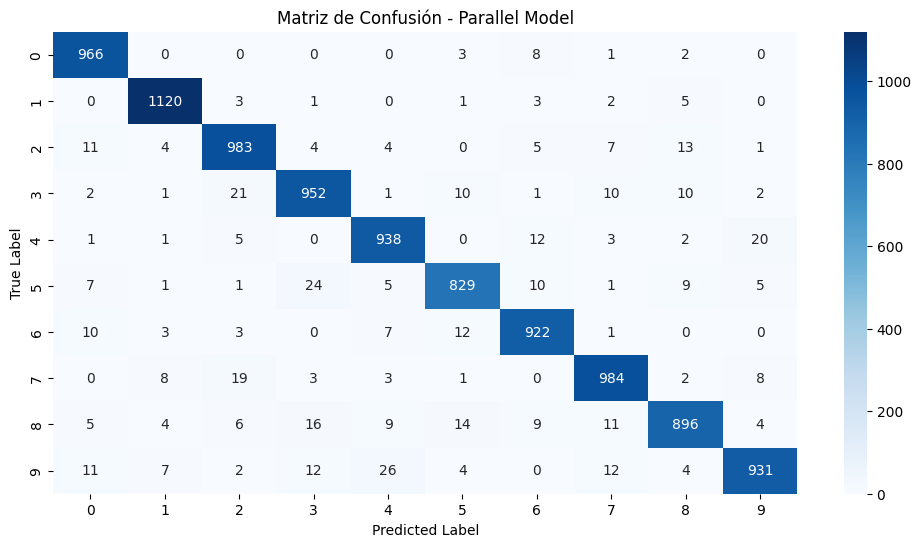

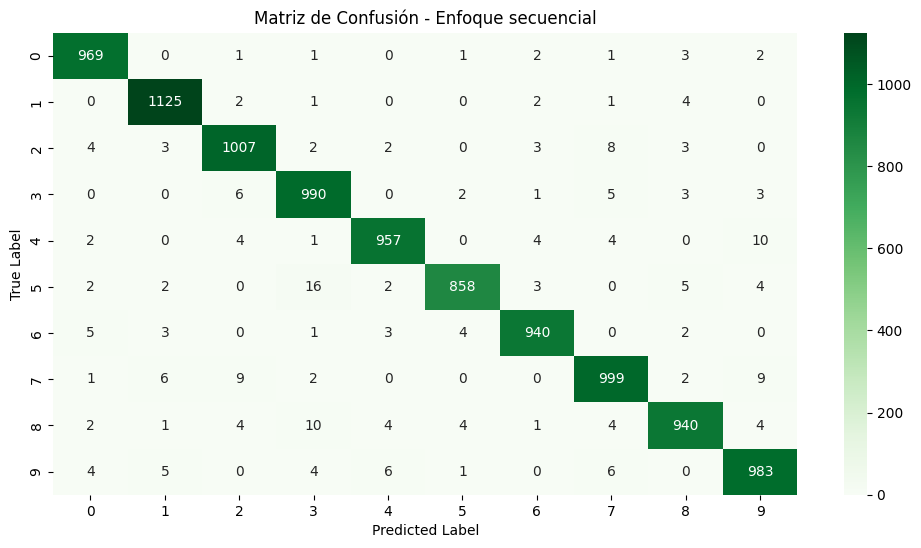

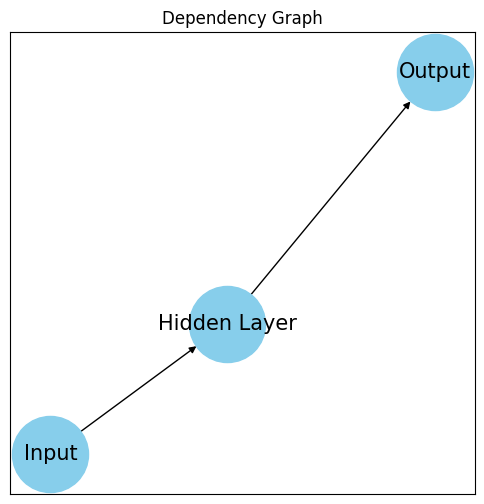

Reporte Matriz de Confusión - Enfoque Paralelo:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.95      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.95      0.96      0.96       958
           7       0.95      0.96      0.96      1028
           8       0.95      0.92      0.93       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Reporte Matriz de Confusión - Enfoque secuencial:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.9

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Parallel Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Compare confusion matrix for sequential model
plt.figure(figsize=(12, 6))
sns.heatmap(seq_conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Enfoque secuencial")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print reports
print("Reporte Matriz de Confusión - Enfoque Paralelo:\n", report)
print("Reporte Matriz de Confusión - Enfoque secuencial:\n", seq_report)


print(f"Tiempo de entrenamiento en paralelo: {end_parallel - start_parallel:.2f} segundos")
print(f"Tiempo de entrenamiento secuencial: {end_sequential - start_sequential:.2f} segundos")